# Information Retrieval System: Domain-Specific Transformer Models for Binary Classification
### Author: Alvaro Gonzalez Mendez
This notebook implements all the code for the fist assignment of Biomedical Informatics Course.


We will be fine tuning diferent transformer-based models in order to make a binary classificator witch detects if a scientific article is related or not to polyphenols. Even if its not what the main taks was, I want to test if Domain-Specific models (BioBERT and BiomedBERT) can perform better than generalistic ones (BERT).


Install required libs and import dependencies

In [ ]:
!pip install -q transformers datasets evaluate pandas 

import torch
import os
import datasets
import pandas as pd
import numpy as np
import evaluate
import requests
import xml.etree.ElementTree as ET
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, average_precision_score
from scipy.special import softmax

First we have to change colab's runtime settings to make use of the GPU hardware accelerator.

In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected.")
    print("If you are using Google Colab, please go to 'Runtime' > 'Change runtime type' and select 'GPU' as the hardware accelerator.")

No GPU detected.
If you are using Google Colab, please go to 'Runtime' > 'Change runtime type' and select 'GPU' as the hardware accelerator.


## Relevant Documents Dataset creation
As we have a document with the titles and not the abstracts of a variety of publications related to the polyphenol, we must extract from the web the abstracts

In [3]:
papersdb = pd.read_excel("publications.xlsx")

In [ ]:
def get_abstract_by_title(article_title):
    # URL base del endpoint de búsqueda de Europe PMC
    base_url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"
    params = {
        "query": f'TITLE:"{article_title}"',
        "format": "json",
        "resultType": "core",
        "pageSize": 1
    }
    print(f"Searching: {article_title}")
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if data.get('hitCount', 0) > 0:
                results = data.get('resultList', {}).get('result', [])
                if results:
                    first_result = results[0]
                    abstract = first_result.get('abstractText') # Get the abstract text directly
                    if abstract: # Check if abstract is not None or empty
                        return abstract # Return the abstract string
                    else:
                        print(f"No abstract was found for: {article_title}")
                        return 2 # Return 2 if no abstract found
                else:
                    print(f"No article was found as: {article_title}")
                    return 0 # Return 0 if no article found in results list
            else:
                 print(f"No article was found as: {article_title}")
                 return 0 # Return 0 if hitCount is 0

    except requests.exceptions.RequestException as e:
        print(f"Connexion Failure for '{article_title}': {e}")
        return 0 # Return 0 for connection failure

In [ ]:
relevant_papers = pd.DataFrame(columns=['title','abstract','relevant'])

not_found_abstracts = []
not_found_paper = []

for index, row in papersdb.iterrows():
    title = row['title']
    abstract = get_abstract_by_title(title)
    if type(abstract) == str:
        paper = [title, abstract, 1]
        relevant_papers.loc[len(relevant_papers)] = paper
    elif abstract == 2:
        not_found_abstracts.append(title)
        not_found_paper.append(title)
    elif abstract == 0:
        not_found_paper.append(title)
    #if index == 100: break
dataset = datasets.Dataset.from_pandas(relevant_papers)
dataset.to_csv("PMC_abstracts.csv", index=False)
with open("not_found_abstracts.txt", "w") as file:
    for item in not_found_abstracts:
        file.write(f"{item}\n")
with open("not_found_paper.txt", "w") as file:
    for item in not_found_paper:
        file.write(f"{item}\n")

Searching: Polyphenol composition and antioxidant activity in strawberry purees  impact of achene level and storage
Searching: Uptake and metabolism of epicatechin and its access to the brain after oral ingestion
Searching: Composition and stability of anthocyanins in blue-grained wheat
Searching: Anthocyanin composition in black, blue, pink, purple, and red cereal grains
Searching: Preliminary study of resveratrol content in Aragon red and rose wines
Searching: HPLC method for the quantification of procyanidins in cocoa and chocolate samples and correlation to total antioxidant capacity
Searching: Enhancement of total phenolics and antioxidant properties of some tropical green leafy vegetables by steam cooking
Searching: Urinary excretion of lignans and isoflavonoid phytoestrogens in Japanese men and women consuming a traditional Japanese diet
Searching: Antioxidant activity of grains
Searching: Phytochemicals and antioxidant activity of milled fractions of different wheat varieties
S

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

As I couldnt retrive the abstracts of arround 300 articles, we are going to use scorpus API to try to retrieve these ones.

In this part its necesary to leave Google colab's enviromet and run locally because is needed to be connected to a network that have access to Scopus API (I used UPMs network). After retrieving the file generated by the cell I returned to colab.

In [ ]:
# Use personal API scorpus key
MI_API_KEY = 'MIKEY'
scopus_url = "https://api.elsevier.com/content/search/scopus"

titles_file_path = 'not_found_paper.txt'
output_csv_file = 'scorpus_abstracts.csv'
not_found_abstracts_file = 'not_found_scorpus.txt'

titles_list = []
if os.path.exists(titles_file_path):
    with open(titles_file_path, 'r') as f:
        titles_list = [line.strip() for line in f if line.strip()]
    print(f"Read {len(titles_list)} titles from '{titles_file_path}'")
else:
    print(f"Error: Titles file '{titles_file_path}' not found.")
    titles_list = []

results_list = []
not_found_abstracts_fp = open(not_found_abstracts_file, 'w')
print(f"Starting search for {len(titles_list)} titles...")
for i, titulo in enumerate(titles_list):
    print(f"\nSearching Scopus for: {titulo}")
    headers = {
        'Accept': 'application/json',
        'X-ELS-APIKey': MI_API_KEY
    }
    params = {
        'query': f'TITLE("{titulo}")',
        'count': 1,
        'view': 'COMPLETE'
    }
    try:
        response = requests.get(scopus_url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        results = data.get('search-results', {}).get('entry', [])
        if results:
            first_result = results[0]
            abstract = first_result.get('dc:description')

            if abstract and abstract.strip():
                print(f"Found abstract for '{titulo[:50]}...': {abstract[:50]}...")

                results_list.append({'title': titulo, 'abstract': abstract, 'relevant': 1})
            else:
                print(f"No abstract found on Scopus for title: {titulo}")
                not_found_abstracts_fp.write(f"{titulo}\n")

        else:
            print(f"No article found on Scopus for title: {titulo}")
            not_found_abstracts_fp.write(f"{titulo}\n")

    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 401:
            print("Error: API Key invalid or expired.")
            not_found_abstracts_fp.write(f"{titulo}\n")
            break
        else:
            print(f"API Error for '{titulo[:50]}...': {e}")
            not_found_abstracts_fp.write(f"{titulo}\n")

    except requests.exceptions.RequestException as e:
        print(f"Network Error for '{titulo[:50]}...': {e}")
        not_found_abstracts_fp.write(f"{titulo}\n")

not_found_abstracts_fp.close()

if results_list:
    results_df = pd.DataFrame(results_list)
    try:
        results_df.to_csv(output_csv_file, index=False)
        print(f"\n--- Scopus Search Process Completed ---")
        print(f"Results with abstracts saved to '{output_csv_file}'")
        print(f"Titles with no abstract found saved to '{not_found_abstracts_file}'")
    except Exception as e:
        print(f"Error saving final CSV file: {e}")
        print(f"Titles with no abstract found saved to '{not_found_abstracts_file}'")

else:
    print("\n--- Scopus Search Process Completed ---")
    print("No abstracts were found for the provided titles.")
    print(f"Titles with no abstract found saved to '{not_found_abstracts_file}'")

Now, we must clean an entry i've found called not aplicable which I interpret as it is an error and not a title.

In [ ]:
input_file = 'scopus_abstracts.csv'
df = pd.read_csv(input_file)
df_limpio = df[df['title'] != 'Not applicable'].copy()
df_limpio.to_csv(input_file, index=False)

Lets merge both csv (Europe PMC and Scorpus)

In [ ]:
file_one = 'PMC_abstracts.csv'
file_two = 'scorpus_abstracts.csv'
output_file = 'polyphenol_relevant_dataset.csv'

df1 = pd.read_csv(file_one)
if '__index_level_0__' in df1.columns:
    df1.drop(columns=['__index_level_0__'], inplace=True)
df1.rename(columns={"relevance": "relevant"}, inplace=True)
df2 = pd.read_csv(file_two)

combined_df = pd.concat([df1, df2], ignore_index=True)

combined_df.to_csv(output_file, index=False)

print(f"Files combined! Saved to: {output_file}")

Files combined! Saved to: polyphenol_relevant_dataset.csv


## Not Relevant Documents Dataset
Now, we have to retrieve the same number of non related (non relevant) documents from pub med in orther to finish our final dataset.

First of all we need to count how many relevant articles we have


In [ ]:
file_path = 'polyphenol_relevant_dataset.csv'

df = pd.read_csv(file_path)
num_entries = len(df)
print(f"The number of entries in '{file_path}' is: {num_entries}")

The number of entries in 'polyphenol_relevant_dataset.csv' is: 1186


Then, we fetch `num_entries` no relevant abstracts



In [ ]:
def create_dataset_from_search(search_term, papers_number):
    paper_set = set()
    esearch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "retmode": "json",
        "term": search_term,
        "retmax": papers_number
    }
    try:
        pmid_response = requests.get(esearch_url, params=params).json()
        id_list = pmid_response.get('esearchresult', {}).get('idlist', [])

        if not id_list:
            print("No PMIDs were found for that search term.")
            return pd.DataFrame(columns=['title', 'abstract', 'relevant']) # Return empty DF

        for pmid in id_list:
            paper_set.add(pmid)

        print(f"Found {len(paper_set)} PMIDs.")

    except Exception as e:
        print(f"Error during Esearch: {e}")
        return pd.DataFrame(columns=['title', 'abstract', 'relevant'])

    results_list = []
    efetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    for i, pmid in enumerate(paper_set):
        print(f"  Processing {i+1}/{len(paper_set)}: PMID {pmid}")
        params_fetch = {
            "db": "pubmed",
            "id": pmid,
            "retmode": "xml"
        }
        try:
            response = requests.get(efetch_url, params=params_fetch, timeout=10)
            response.raise_for_status()

            root = ET.fromstring(response.text)
            article = root.find(".//PubmedArticle")

            if article is None:
                print(f"    'PubmedArticle' not found for {pmid}. Skipping.")
                continue

            title = article.findtext(".//ArticleTitle") or "No Title Found"

            abstract_parts = [elem.text for elem in article.findall(".//Abstract/AbstractText") if elem.text]
            abstract = " ".join(abstract_parts) or "No Abstract Found"

            results_list.append({
                'title': title,
                'abstract': abstract,
                'relevant': 0
            })

            time.sleep(0.3)

        except Exception as e:
            print(f"    Error processing {pmid}: {e}")

    print("\nProcess completed. Creating DataFrame.")
    df = pd.DataFrame(results_list)
    return df

NUMBER_OF_ARTICLES = num_entries
SEARCH_TERM = "NOT polyphenol"

non_relevant_df = create_dataset_from_search(SEARCH_TERM, NUMBER_OF_ARTICLES)

if not non_relevant_df.empty:
    print("\n--- First 5 Results ---")
    print(non_relevant_df.head())

    output_filename = "non_relevant_articles.csv"
    non_relevant_df.to_csv(output_filename, index=False, encoding='utf-8')
    print(f"\nData saved to {output_filename}")
else:
    print("No data was generated.")

Found 1186 PMIDs.
  Processing 1/1186: PMID 41174414
  Processing 2/1186: PMID 41187852
  Processing 3/1186: PMID 40945458
  Processing 4/1186: PMID 40995184
  Processing 5/1186: PMID 40936471
  Processing 6/1186: PMID 41164934
  Processing 7/1186: PMID 41008240
  Processing 8/1186: PMID 40964682
  Processing 9/1186: PMID 41010902
  Processing 10/1186: PMID 41160200
  Processing 11/1186: PMID 40990910
  Processing 12/1186: PMID 40946566
  Processing 13/1186: PMID 40907242
  Processing 14/1186: PMID 41201340
  Processing 15/1186: PMID 41042201
  Processing 16/1186: PMID 41008654
  Processing 17/1186: PMID 41114530
  Processing 18/1186: PMID 41183758
  Processing 19/1186: PMID 41146042
  Processing 20/1186: PMID 41116723
  Processing 21/1186: PMID 41110409
  Processing 22/1186: PMID 41043258
  Processing 23/1186: PMID 41009551
  Processing 24/1186: PMID 41061287
  Processing 25/1186: PMID 40987979
  Processing 26/1186: PMID 41154486
  Processing 27/1186: PMID 40918167
  Processing 28/118

To end our dataset we must merge both, relevant and non relevant datasets.

In [ ]:
file_one = 'polyphenol_relevant_dataset.csv'
file_two = 'non_relevant_articles.csv'
output_file = 'polyphenol_dataset.csv'

df1 = pd.read_csv(file_one)
df2 = pd.read_csv(file_two)

combined_df = pd.concat([df1, df2], ignore_index=True)

combined_df.to_csv(output_file, index=False)

print(f"Files combined! Saved to: {output_file}")

Files combined! Saved to: polyphenol_dataset.csv


## Dataset Load
Now, we will load our dataset and check if we have 50/50 distributed our documents

In [9]:
dataset = datasets.load_dataset("csv",data_files="polyphenol_dataset.csv")

print(dataset['train'])

pdds = dataset['train'].to_pandas()
label_count = pdds['relevant'].value_counts()

print(label_count)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['title', 'abstract', 'relevant'],
    num_rows: 2371
})
relevant
1    1186
0    1185
Name: count, dtype: int64


Then, we will split this dataset in 3 parts:


*   Train set → 70% of the cases.
*   Validation set → 15% of the cases.
*   Test set → 15% of the cases.

All this sets must have the same relevant documents as irrelevant



In [10]:
SEED = 25
original_train_data = dataset['train']

original_train_data = original_train_data.cast_column(
    "relevant",
    datasets.ClassLabel(names=["0", "1"])
)

# 1. Split dataset 70% and 30%
temp_split = original_train_data.train_test_split(
    test_size=0.30,
    stratify_by_column="relevant",
    seed=SEED
)

# 2. Split 30% into 15% and 15%
validation_test_split = temp_split['test'].train_test_split(
    test_size=(.5),
    stratify_by_column="relevant",
    seed=SEED
)

# 3. Create the final dataset
poly_dataset = datasets.DatasetDict({
    'train': temp_split['train'],
    'test': validation_test_split['test'],
    'validation': validation_test_split['train']
})

print("--- Dataset split and stratified ---")
print(poly_dataset)

# --- Optional Verification ---
print("\n--- Stratification Verification ---")
total_size = len(original_train_data)
print(f"Original Distribution (Total: {total_size}):")
print(f"  {Counter(original_train_data['relevant'])}")

print(f"\n'train' Distribution (Total: {len(poly_dataset['train'])}):")
print(f"  {Counter(poly_dataset['train']['relevant'])}")

print(f"\n'test' Distribution (Total: {len(poly_dataset['validation'])}):")
print(f"  {Counter(poly_dataset['validation']['relevant'])}")

print(f"\n'validation' Distribution (Total: {len(poly_dataset['test'])}):")
print(f"  {Counter(poly_dataset['test']['relevant'])}")

Casting the dataset:   0%|          | 0/2371 [00:00<?, ? examples/s]

--- Dataset split and stratified ---
DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'relevant'],
        num_rows: 1659
    })
    test: Dataset({
        features: ['title', 'abstract', 'relevant'],
        num_rows: 356
    })
    validation: Dataset({
        features: ['title', 'abstract', 'relevant'],
        num_rows: 356
    })
})

--- Stratification Verification ---
Original Distribution (Total: 2371):
  Counter({1: 1186, 0: 1185})

'train' Distribution (Total: 1659):
  Counter({1: 830, 0: 829})

'test' Distribution (Total: 356):
  Counter({0: 178, 1: 178})

'validation' Distribution (Total: 356):
  Counter({0: 178, 1: 178})


## Common code for training the 3 models

As we are going to make 3 diferent model tunes, most of the code will still be the same, so all the code that can be implemented only once will be coded here.

Load the evaluation metrics

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Config training parameters

In [ ]:
training_args = TrainingArguments(
    output_dir="polyphenol_paper_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    num_train_epochs=10.0,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

## Fine-Tuning BERT
Now, we already have our dataset properly acomodated, we can now start tuning BERT in order to create the binary classificator.

I will use as a base the tutorial from HuggingFace: https://huggingface.co/docs/transformers/training

In [11]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize(examples):
    return tokenizer(examples["abstract"], padding="max_length", truncation=True)

dataset = poly_dataset.map(tokenize, batched=True)

# Rename the 'relevant' column to 'labels'
dataset = dataset.rename_column("relevant", "labels")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1659 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Lets load the model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.300390,0.918539
2,No log,0.077961,0.985955
3,0.162600,0.092343,0.980337
4,0.162600,0.163528,0.974719
5,0.037300,0.067068,0.988764
6,0.037300,0.208583,0.966292
7,0.037300,0.093432,0.988764
8,0.006500,0.096461,0.988764
9,0.006500,0.097954,0.988764
10,0.000000,0.098421,0.988764


TrainOutput(global_step=2080, training_loss=0.04961744826343, metrics={'train_runtime': 1799.9444, 'train_samples_per_second': 9.217, 'train_steps_per_second': 1.156, 'total_flos': 4365012408422400.0, 'train_loss': 0.04961744826343, 'epoch': 10.0})

In [ ]:
test_results = trainer.evaluate(eval_dataset=dataset['test'])

print("\nTest Results (Final Evaluation):")
print(test_results)


Validation Results (Final Evaluation):
{'eval_loss': 0.13653257489204407, 'eval_accuracy': 0.9747191011235955, 'eval_runtime': 9.5, 'eval_samples_per_second': 37.474, 'eval_steps_per_second': 4.737, 'epoch': 10.0}


Save, Zip and Download from colab the fine-tuned model and the tokenizer

In [ ]:
dir = "model"

model.save_pretrained(dir)
tokenizer.save_pretrained(dir)
print(f"Model and tokenizer saved to directory: {dir}")

Model and tokenizer saved to directory: model


In [ ]:
!zip -r /content/modelBERT.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/config.json (deflated 49%)
  adding: content/model/special_tokens_map.json (deflated 42%)
  adding: content/model/model.safetensors (deflated 7%)
  adding: content/model/vocab.txt (deflated 49%)
  adding: content/model/tokenizer_config.json (deflated 75%)
  adding: content/model/tokenizer.json (deflated 70%)


In [ ]:
from google.colab import files
files.download('/content/modelBERT.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fine-Tuning BioBERT

Once we have our general model BERT fine-tuned, I will use a version of BERT trainde with biology resources, as we are retreaving biomedical info, this should lead to better results.

This second model can be found in: https://huggingface.co/dmis-lab/biobert-v1.1

Following the same exact results as with BERT:

In [12]:
bio_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

def tokenize(examples):
    return bio_tokenizer(examples["abstract"], padding="max_length", truncation=True)

bio_dataset = poly_dataset.map(tokenize, batched=True)

# Rename the 'relevant' column to 'labels'
bio_dataset = bio_dataset.rename_column("relevant", "labels")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1659 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Lets load the model

In [ ]:
bio_model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bio_trainer = Trainer(
    model=bio_model,
    args=training_args,
    train_dataset=bio_dataset['train'],
    eval_dataset=bio_dataset['validation'],
    compute_metrics=compute_metrics,
)
bio_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.123328,0.977528
2,No log,0.140418,0.966292
3,0.111100,0.069986,0.985955
4,0.111100,0.044770,0.994382
5,0.020600,0.045917,0.991573
6,0.020600,0.044378,0.994382
7,0.020600,0.049387,0.994382
8,0.000800,0.050908,0.994382
9,0.000800,0.051813,0.994382
10,0.000000,0.052086,0.994382


TrainOutput(global_step=2080, training_loss=0.0318663058923938, metrics={'train_runtime': 1839.0041, 'train_samples_per_second': 9.021, 'train_steps_per_second': 1.131, 'total_flos': 4365012408422400.0, 'train_loss': 0.0318663058923938, 'epoch': 10.0})

In [ ]:
bio_test_results = bio_trainer.evaluate(eval_dataset=bio_dataset['test'])

print("\nTest Results (Final Evaluation):")
print(bio_test_results)


Validation Results (Final Evaluation):
{'eval_loss': 0.06684485077857971, 'eval_accuracy': 0.9887640449438202, 'eval_runtime': 10.0492, 'eval_samples_per_second': 35.426, 'eval_steps_per_second': 4.478, 'epoch': 10.0}


In [51]:
bio_dir = "bio-model"

bio_model.save_pretrained(bio_dir)
bio_tokenizer.save_pretrained(bio_dir)
print(f"Model and tokenizer saved to directory: {bio_dir}")

Model and tokenizer saved to directory: bio-model


In [52]:
!zip -r /content/modelBioBERT.zip /content/bio-model

  adding: content/bio-model/ (stored 0%)
  adding: content/bio-model/config.json (deflated 49%)
  adding: content/bio-model/special_tokens_map.json (deflated 42%)
  adding: content/bio-model/model.safetensors (deflated 7%)
  adding: content/bio-model/vocab.txt (deflated 49%)
  adding: content/bio-model/tokenizer_config.json (deflated 75%)
  adding: content/bio-model/tokenizer.json (deflated 70%)


In [53]:
from google.colab import files
files.download('/content/modelBioBERT.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fine-Tuning BiomedBERT

Once we have both our general model BERT, and the biology specialist fine-tuned, I will use a version of BERT trained with PubMed publications BiomedBERT published by Microsoft. This model shoud give us the best results for our clasification.

BiomedBERT has reciently change named, the original name for the model was PubMedBERT (abstracts + full text)

The model can be found in: https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext

Following the same exact results as with BERT:

In [13]:
biomed_tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")

def tokenize(examples):
    return biomed_tokenizer(examples["abstract"], padding="max_length", truncation=True, max_length=512)

biomed_dataset = poly_dataset.map(tokenize, batched=True)

# Rename the 'relevant' column to 'labels'
biomed_dataset = biomed_dataset.rename_column("relevant", "labels")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1659 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Lets load the model

In [55]:
biomed_model = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
biomed_trainer = Trainer(
    model=biomed_model,
    args=training_args,
    train_dataset=biomed_dataset['train'],
    eval_dataset=biomed_dataset['validation'],
    compute_metrics=compute_metrics,
)
biomed_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.091221,0.977528
2,No log,0.022034,0.997191
3,0.098400,0.038159,0.994382
4,0.098400,0.096092,0.980337
5,0.011500,0.061464,0.991573
6,0.011500,0.053426,0.991573
7,0.011500,0.052499,0.994382
8,0.000700,0.052657,0.994382
9,0.000700,0.052933,0.994382
10,0.000000,0.052880,0.994382


TrainOutput(global_step=2080, training_loss=0.026566268186769985, metrics={'train_runtime': 2063.8662, 'train_samples_per_second': 8.038, 'train_steps_per_second': 1.008, 'total_flos': 4365012408422400.0, 'train_loss': 0.026566268186769985, 'epoch': 10.0})

In [57]:
biomed_test_results = biomed_trainer.evaluate(eval_dataset=biomed_dataset['test'])

print("\nTest Results (Final Evaluation):")
print(biomed_test_results)


Validation Results (Final Evaluation):
{'eval_loss': 0.05078006163239479, 'eval_accuracy': 0.9887640449438202, 'eval_runtime': 9.9211, 'eval_samples_per_second': 35.883, 'eval_steps_per_second': 4.536, 'epoch': 10.0}


In [58]:
biomed_dir = "biomed-model"

biomed_model.save_pretrained(biomed_dir)
biomed_tokenizer.save_pretrained(biomed_dir)
print(f"Model and tokenizer saved to directory: {biomed_dir}")

Model and tokenizer saved to directory: biomed-model


In [59]:
!zip -r /content/modelBiomedBERT.zip /content/biomed-model

  adding: content/biomed-model/ (stored 0%)
  adding: content/biomed-model/config.json (deflated 49%)
  adding: content/biomed-model/special_tokens_map.json (deflated 42%)
  adding: content/biomed-model/model.safetensors (deflated 7%)
  adding: content/biomed-model/vocab.txt (deflated 52%)
  adding: content/biomed-model/tokenizer_config.json (deflated 74%)
  adding: content/biomed-model/tokenizer.json (deflated 71%)


In [60]:
from google.colab import files
files.download('/content/modelBiomedBERT.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Models Comparation
Finally we are going to calculate some metrics to evaluate our model's performance.

We will obtain the confussion matrix, the precision and the recall for each model. Also we will be graphing a ROC Curve and calculating the area under the curve AUC to compare the models.

First, we need to load the 3 models (if we have not trained in the same session)

In [2]:
!unzip modelBERT.zip
!unzip modelBioBERT.zip
!unzip modelBiomedBERT.zip

Archive:  modelBERT.zip
   creating: content/model/
  inflating: content/model/config.json  
  inflating: content/model/special_tokens_map.json  
  inflating: content/model/model.safetensors  
  inflating: content/model/vocab.txt  
  inflating: content/model/tokenizer_config.json  
  inflating: content/model/tokenizer.json  
Archive:  modelBioBERT.zip
   creating: content/bio-model/
  inflating: content/bio-model/config.json  
  inflating: content/bio-model/special_tokens_map.json  
  inflating: content/bio-model/model.safetensors  
  inflating: content/bio-model/vocab.txt  
  inflating: content/bio-model/tokenizer_config.json  
  inflating: content/bio-model/tokenizer.json  
Archive:  modelBiomedBERT.zip
   creating: content/biomed-model/
  inflating: content/biomed-model/config.json  
  inflating: content/biomed-model/special_tokens_map.json  
  inflating: content/biomed-model/model.safetensors  
  inflating: content/biomed-model/vocab.txt  
  inflating: content/biomed-model/tokenize

In [15]:
training_args = TrainingArguments(
    report_to="none",
    output_dir="./temp_results"
)

base_model_dir = "content/model"
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_dir)
base_tokenizer = AutoTokenizer.from_pretrained(base_model_dir)

trainer = Trainer(
    model=base_model,
    args=training_args,
)

print("Tuned BERT model and tokenizer Loaded")

bio_model_dir = "content/bio-model"
bio_model = AutoModelForSequenceClassification.from_pretrained(bio_model_dir)
bio_tokenizer = AutoTokenizer.from_pretrained(bio_model_dir)

bio_trainer = Trainer(
    model=bio_model,
    args=training_args,
)

print("Tuned BioBERT model and tokenizer Loaded")

biomed_model_dir = "content/biomed-model"
biomed_model = AutoModelForSequenceClassification.from_pretrained(biomed_model_dir)
biomed_tokenizer = AutoTokenizer.from_pretrained(biomed_model_dir)

biomed_trainer = Trainer(
    model=biomed_model,
    args=training_args,
)

print("Tuned BiomedBERT model and tokenizer Loaded")

Tuned BERT model and tokenizer Loaded
Tuned BioBERT model and tokenizer Loaded
Tuned BiomedBERT model and tokenizer Loaded


### Calc ROC Curve

Running predictions on the validation set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Calculating probabilities (Softmax)...
Calculating ROC metrics...
The BERT model's AUC (Area Under the Curve) is: 0.9981
The BioBERT model's AUC (Area Under the Curve) is: 0.9979
The BiomedBERT model's AUC (Area Under the Curve) is: 0.9996
Generating ROC plot and saving to 'roc_curve.png'...

ROC plot saved as 'roc_curve.png'!


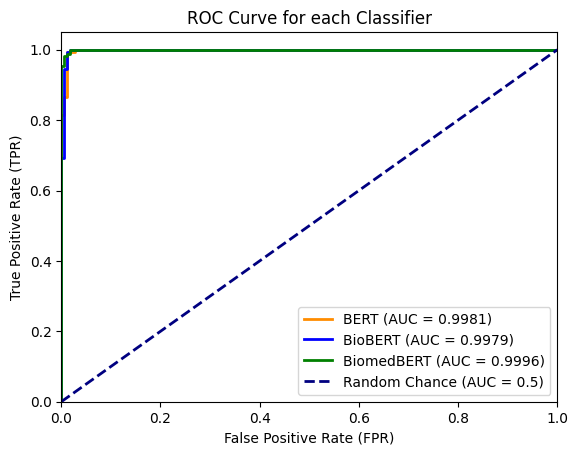

In [16]:
print("Running predictions on the test set...")
base_prediction_output = trainer.predict(dataset['test'])
bio_prediction_output = bio_trainer.predict(bio_dataset['test'])
biomed_prediction_output = biomed_trainer.predict(biomed_dataset['test'])

base_logits = base_prediction_output.predictions
base_y_true = base_prediction_output.label_ids

bio_logits = bio_prediction_output.predictions
bio_y_true = bio_prediction_output.label_ids

biomed_logits = biomed_prediction_output.predictions
biomed_y_true = biomed_prediction_output.label_ids

print("Calculating probabilities (Softmax)...")
base_y_probas = softmax(base_logits, axis=1)
bio_y_probas = softmax(bio_logits, axis=1)
biomed_y_probas = softmax(biomed_logits, axis=1)

base_y_scores = base_y_probas[:, 1]
bio_y_scores = bio_y_probas[:, 1]
biomed_y_scores = biomed_y_probas[:, 1]

print("Calculating ROC metrics...")
base_auc_score = roc_auc_score(base_y_true, base_y_scores)
bio_auc_score = roc_auc_score(bio_y_true, bio_y_scores)
biomed_auc_score = roc_auc_score(biomed_y_true, biomed_y_scores)
print(f"The BERT model's AUC (Area Under the Curve) is: {base_auc_score:.4f}")
print(f"The BioBERT model's AUC (Area Under the Curve) is: {bio_auc_score:.4f}")
print(f"The BiomedBERT model's AUC (Area Under the Curve) is: {biomed_auc_score:.4f}")

# Calculate the curve's points (FPR, TPR)
# fpr = False Positive Rate
# tpr = True Positive Rate
base_fpr, base_tpr, base_thresholds = roc_curve(base_y_true, base_y_scores)
bio_fpr, bio_tpr, bio_thresholds = roc_curve(bio_y_true, bio_y_scores)
biomed_fpr, biomed_tpr, biomed_thresholds = roc_curve(biomed_y_true, biomed_y_scores)

print("Generating ROC plot and saving to 'roc_curve.png'...")
plt.figure()

plt.plot(base_fpr, base_tpr, color='darkorange', lw=2, label=f'BERT (AUC = {base_auc_score:.4f})')
plt.plot(bio_fpr, bio_tpr, color='blue', lw=2, label=f'BioBERT (AUC = {bio_auc_score:.4f})')
plt.plot(biomed_fpr, biomed_tpr, color='green', lw=2, label=f'BiomedBERT (AUC = {biomed_auc_score:.4f})')

# Plot the "random chance" line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for each Classifier')
plt.legend(loc="lower right")

# Save the figure to a file
plt.savefig("roc_curve.png")

print("\nROC plot saved as 'roc_curve.png'!")

Calculating predicted classes (argmax)...

     CLASSIFICATION REPORT: BERT (Base)
                  precision    recall  f1-score   support

Not Relevant (0)       0.96      0.99      0.98       178
    Relevant (1)       0.99      0.96      0.97       178

        accuracy                           0.97       356
       macro avg       0.98      0.97      0.97       356
    weighted avg       0.98      0.97      0.97       356


     CLASSIFICATION REPORT: BioBERT
                  precision    recall  f1-score   support

Not Relevant (0)       0.99      0.98      0.99       178
    Relevant (1)       0.98      0.99      0.99       178

        accuracy                           0.99       356
       macro avg       0.99      0.99      0.99       356
    weighted avg       0.99      0.99      0.99       356


     CLASSIFICATION REPORT: BiomedBERT
                  precision    recall  f1-score   support

Not Relevant (0)       0.99      0.99      0.99       178
    Relevant (1)     

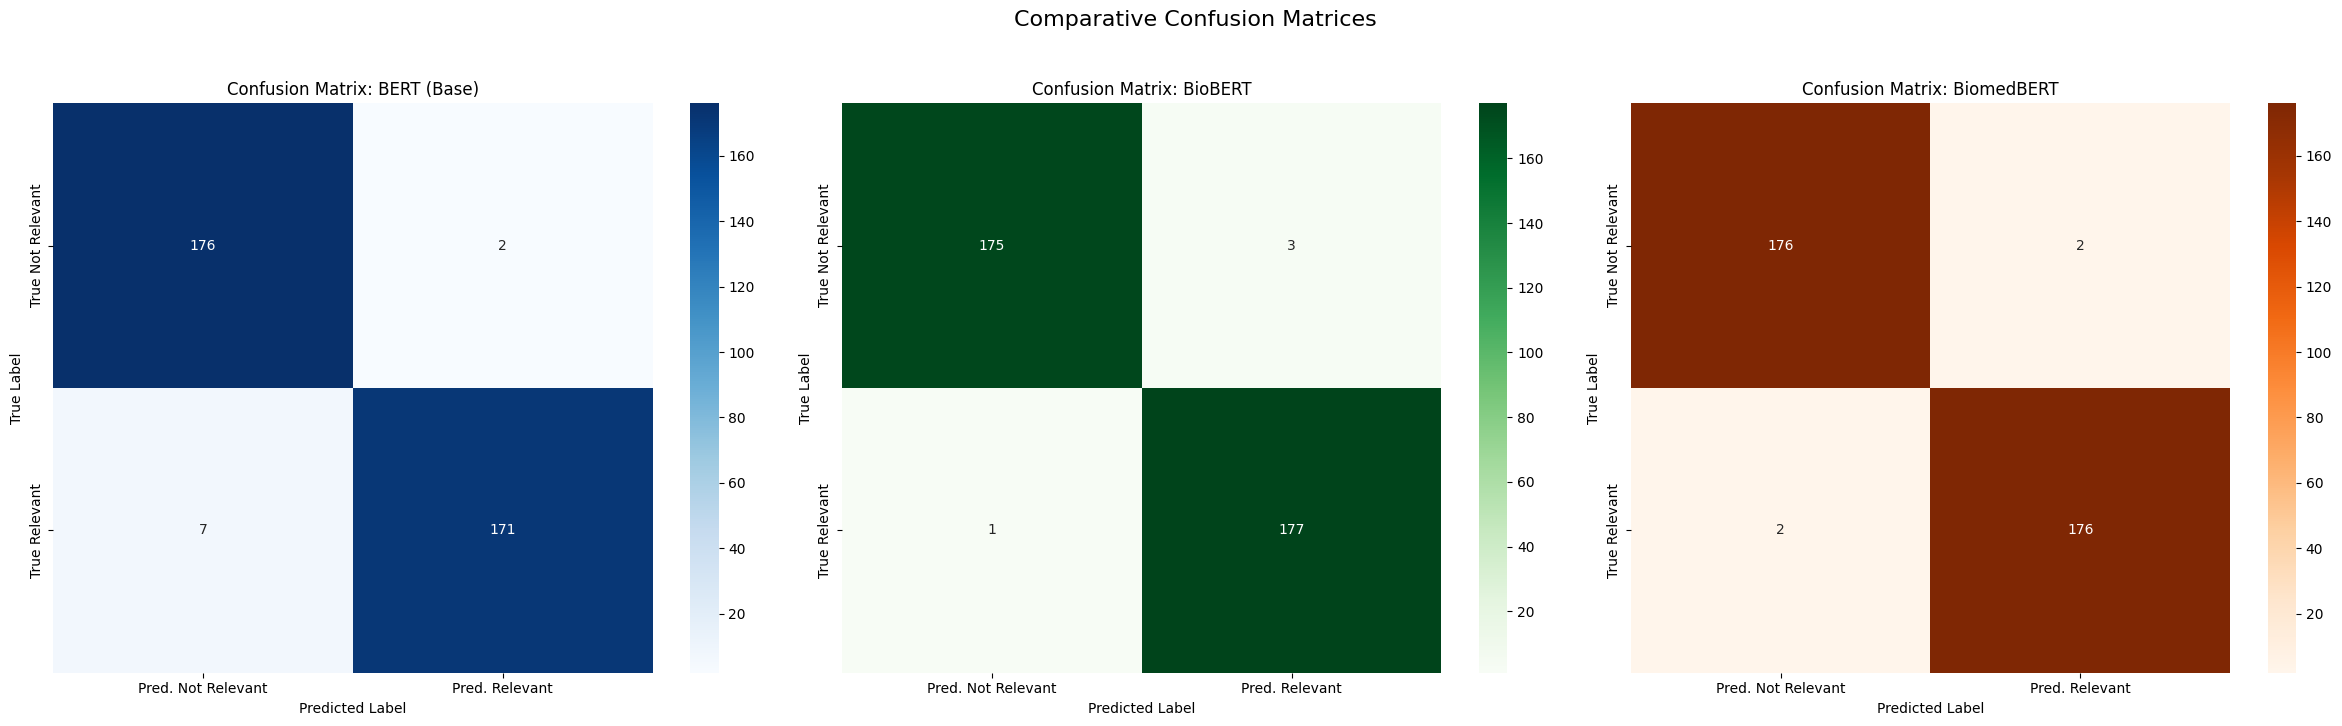

In [17]:
print("Calculating predicted classes (argmax)...")
base_y_pred = np.argmax(base_logits, axis=1)
bio_y_pred = np.argmax(bio_logits, axis=1)
biomed_y_pred = np.argmax(biomed_logits, axis=1)

target_names = ['Not Relevant (0)', 'Relevant (1)']

print("\n" + "="*40)
print("     CLASSIFICATION REPORT: BERT (Base)")
print("="*40)
print(classification_report(base_y_true, base_y_pred, target_names=target_names))

print("\n" + "="*40)
print("     CLASSIFICATION REPORT: BioBERT")
print("="*40)
print(classification_report(bio_y_true, bio_y_pred, target_names=target_names))

print("\n" + "="*40)
print("     CLASSIFICATION REPORT: BiomedBERT")
print("="*40)
print(classification_report(biomed_y_true, biomed_y_pred, target_names=target_names))

print("Calculating confusion matrices...")
cm_base = confusion_matrix(base_y_true, base_y_pred)
cm_bio = confusion_matrix(bio_y_true, bio_y_pred)
cm_biomed = confusion_matrix(biomed_y_true, biomed_y_pred)

print("Generating confusion matrix plots...")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Comparative Confusion Matrices', fontsize=16, y=1.03)

axis_labels = ['True Not Relevant', 'True Relevant']
pred_labels = ['Pred. Not Relevant', 'Pred. Relevant']

sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=pred_labels, yticklabels=axis_labels)
axes[0].set_title('Confusion Matrix: BERT (Base)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_bio, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=pred_labels, yticklabels=axis_labels)
axes[1].set_title('Confusion Matrix: BioBERT')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

sns.heatmap(cm_biomed, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=pred_labels, yticklabels=axis_labels)
axes[2].set_title('Confusion Matrix: BiomedBERT')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig("confusion_matrices_comparison.png")

print("\nComparative confusion matrix plot saved as 'confusion_matrices_comparison.png'!")

As the classification report function lacks givin values only with 2 decimals, I've implemented the next code in order to obtain values with higher precision

In [18]:
precision_base = precision_score(base_y_true, base_y_pred, average='weighted')
recall_base = recall_score(base_y_true, base_y_pred, average='weighted')
f1_base = f1_score(base_y_true, base_y_pred, average='weighted')

print("\n--- BERT (Base) - High Precision Metrics ---")
print(f"Precision: {precision_base}")
print(f"Recall:    {recall_base}")
print(f"F1-Score:  {f1_base}")

precision_bio = precision_score(bio_y_true, bio_y_pred, average='weighted')
recall_bio = recall_score(bio_y_true, bio_y_pred, average='weighted')
f1_bio = f1_score(bio_y_true, bio_y_pred, average='weighted')

print("\n--- BioBERT - High Precision Metrics ---")
print(f"Precision: {precision_bio}")
print(f"Recall:    {recall_bio}")
print(f"F1-Score:  {f1_bio}")

precision_biomed = precision_score(biomed_y_true, biomed_y_pred, average='weighted')
recall_biomed = recall_score(biomed_y_true, biomed_y_pred, average='weighted')
f1_biomed = f1_score(biomed_y_true, biomed_y_pred, average='weighted')

print("\n--- BiomedBERT - High Precision Metrics ---")
print(f"Precision: {precision_biomed}")
print(f"Recall:    {recall_biomed}")
print(f"F1-Score:  {f1_biomed}")


--- BERT (Base) - High Precision Metrics ---
Precision: 0.9750939701190814
Recall:    0.9747191011235955
F1-Score:  0.9747141132182683

--- BioBERT - High Precision Metrics ---
Precision: 0.9888257575757575
Recall:    0.9887640449438202
F1-Score:  0.9887636903071046

--- BiomedBERT - High Precision Metrics ---
Precision: 0.9887640449438202
Recall:    0.9887640449438202
F1-Score:  0.9887640449438202


Ranking Metrics

In [20]:
model_names = []
p_at_5_list = []
p_at_10_list = []
r_prec_list = []
avg_prec_list = []
rr_list = []

print("Calculating Ranking Metrics (P@5, P@10, R-Prec, AvgPrec, RR)...")

# 1. BERT (Base)
print("\n--- Ranking Metrics: BERT (Base) ---")
model_names.append("BERT (Base)")
y_true = np.array(base_y_true)
y_scores = np.array(base_y_scores)

sorted_indices = np.argsort(y_scores)[::-1]
sorted_labels = y_true[sorted_indices]

R = np.sum(sorted_labels)
if R == 0:
    p_at_5_list.append(0.0)
    p_at_10_list.append(0.0)
    r_prec_list.append(0.0)
    avg_prec_list.append(0.0)
    rr_list.append(0.0)
else:
    p_at_5 = np.sum(sorted_labels[:5]) / 5.0
    p_at_5_list.append(p_at_5)

    p_at_10 = np.sum(sorted_labels[:10]) / 10.0
    p_at_10_list.append(p_at_10)

    r_precision = np.sum(sorted_labels[:int(R)]) / R
    r_prec_list.append(r_precision)

    avg_precision = average_precision_score(y_true, y_scores)
    avg_prec_list.append(avg_precision)

    try:
        first_relevant_index = np.nonzero(sorted_labels)[0][0]
        rr = 1.0 / (first_relevant_index + 1) 
    except IndexError:
        rr = 0.0 
    rr_list.append(rr)

    print(f"Total Relevant Documents (R): {int(R)}")
    print(f"P@5:      {p_at_5:.4f}")
    print(f"P@10:     {p_at_10:.4f}")
    print(f"R-Prec:   {r_precision:.4f}")
    print(f"Avg Prec: {avg_precision:.4f}")
    print(f"RR:       {rr:.4f}")


# 2. BioBERT
print("\n--- Ranking Metrics: BioBERT ---")
model_names.append("BioBERT")
y_true = np.array(bio_y_true)
y_scores = np.array(bio_y_scores)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_labels = y_true[sorted_indices]
R = np.sum(sorted_labels)

if R == 0:
    p_at_5_list.append(0.0)
    p_at_10_list.append(0.0)
    r_prec_list.append(0.0)
    avg_prec_list.append(0.0)
    rr_list.append(0.0)
else:
    p_at_5 = np.sum(sorted_labels[:5]) / 5.0; p_at_5_list.append(p_at_5)
    p_at_10 = np.sum(sorted_labels[:10]) / 10.0; p_at_10_list.append(p_at_10)
    r_precision = np.sum(sorted_labels[:int(R)]) / R; r_prec_list.append(r_precision)
    avg_precision = average_precision_score(y_true, y_scores); avg_prec_list.append(avg_precision)
    try:
        first_relevant_index = np.nonzero(sorted_labels)[0][0]
        rr = 1.0 / (first_relevant_index + 1)
    except IndexError:
        rr = 0.0
    rr_list.append(rr)
    print(f"Total Relevant Documents (R): {int(R)}")
    print(f"P@5:      {p_at_5:.4f}")
    print(f"P@10:     {p_at_10:.4f}")
    print(f"R-Prec:   {r_precision:.4f}")
    print(f"Avg Prec: {avg_precision:.4f}")
    print(f"RR:       {rr:.4f}")


# 3. BiomedBERT
print("\n--- Ranking Metrics: BiomedBERT ---")
model_names.append("BiomedBERT")
y_true = np.array(biomed_y_true)
y_scores = np.array(biomed_y_scores)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_labels = y_true[sorted_indices]
R = np.sum(sorted_labels)

if R == 0:
    p_at_5_list.append(0.0)
    p_at_10_list.append(0.0)
    r_prec_list.append(0.0)
    avg_prec_list.append(0.0)
    rr_list.append(0.0)
else:
    p_at_5 = np.sum(sorted_labels[:5]) / 5.0; p_at_5_list.append(p_at_5)
    p_at_10 = np.sum(sorted_labels[:10]) / 10.0; p_at_10_list.append(p_at_10)
    r_precision = np.sum(sorted_labels[:int(R)]) / R; r_prec_list.append(r_precision)
    avg_precision = average_precision_score(y_true, y_scores); avg_prec_list.append(avg_precision)
    try:
        first_relevant_index = np.nonzero(sorted_labels)[0][0]
        rr = 1.0 / (first_relevant_index + 1)
    except IndexError:
        rr = 0.0
    rr_list.append(rr)
    print(f"Total Relevant Documents (R): {int(R)}")
    print(f"P@5:      {p_at_5:.4f}")
    print(f"P@10:     {p_at_10:.4f}")
    print(f"R-Prec:   {r_precision:.4f}")
    print(f"Avg Prec: {avg_precision:.4f}")
    print(f"RR:       {rr:.4f}")

print("\n" + "="*50)
print("       SUMMARY TABLE OF RANKING METRICS")
print("="*50)
print(f"{'Model':<15} | {'P@5':<8} | {'P@10':<8} | {'R-Prec':<8} | {'AvgPrec':<8} | {'RR':<8}")
print("-" * 50)
for i in range(len(model_names)):
    print(f"{model_names[i]:<15} | {p_at_5_list[i]:<8.4f} | {p_at_10_list[i]:<8.4f} | {r_prec_list[i]:<8.4f} | {avg_prec_list[i]:<8.4f} | {rr_list[i]:<8.4f}")

Calculating Ranking Metrics (P@5, P@10, R-Prec, AvgPrec, RR)...

--- Ranking Metrics: BERT (Base) ---
Total Relevant Documents (R): 178
P@5:      1.0000
P@10:     1.0000
R-Prec:   0.9888
Avg Prec: 0.9980
RR:       1.0000

--- Ranking Metrics: BioBERT ---
Total Relevant Documents (R): 178
P@5:      1.0000
P@10:     1.0000
R-Prec:   0.9888
Avg Prec: 0.9976
RR:       1.0000

--- Ranking Metrics: BiomedBERT ---
Total Relevant Documents (R): 178
P@5:      1.0000
P@10:     1.0000
R-Prec:   0.9888
Avg Prec: 0.9996
RR:       1.0000

       SUMMARY TABLE OF RANKING METRICS
Model           | P@5      | P@10     | R-Prec   | AvgPrec  | RR      
--------------------------------------------------
BERT (Base)     | 1.0000   | 1.0000   | 0.9888   | 0.9980   | 1.0000  
BioBERT         | 1.0000   | 1.0000   | 0.9888   | 0.9976   | 1.0000  
BiomedBERT      | 1.0000   | 1.0000   | 0.9888   | 0.9996   | 1.0000  
